# Temperature Statistics for Europe

This dataset provides temperature exposure statistics for Europe, focusing on daily 2-meter air temperature (mean, minimum, and maximum) for entire years, as well as for winter (DJF) and summer (JJA) seasons. Derived using bias-adjusted EURO-CORDEX data, the statistics span a smoothed 30-year average from 1971 to 2100, resulting in a timeseries from 1986 to 2085, with model ensemble averages and associated standard deviations included. These temperature percentiles are crucial in public health and epidemiology for assessing health risks and impacts, enabling comparisons across regions under various climate change scenarios.

**Information on Dataset:**
* Source: <a href="https://cds.climate.copernicus.eu/datasets/sis-temperature-statistics?tab=overview" target="_blank">Temperature Statistics for Europe</a>
* Author: T. Tewes (Stadt Konstanz) 
* Notebook Version: 1.2 (Updated: January 24, 2024)

## 1. Specifying the paths and working directories

In [1]:
import os

''' ---- Specify Directories Here ---- '''
download_folder = r".\data\sis-temperature-statistics\download"
working_folder = r".\data\sis-temperature-statistics\working"
geotiff_folder = r".\data\sis-temperature-statistics\geotiff"
csv_folder = r".\data\sis-temperature-statistics\csv"
output_folder = r".\data\sis-temperature-statistics\output"
''' ----- End of Declaration ---- '''

os.makedirs(download_folder, exist_ok=True)
os.makedirs(working_folder, exist_ok=True)
os.makedirs(geotiff_folder, exist_ok=True)
os.makedirs(csv_folder, exist_ok=True)
os.makedirs(output_folder, exist_ok=True)

## 2. Download and Extract the Dataset

### 2.1 Authentication

In [2]:
import cdsapi

def main():
    # API key for authentication
    api_key = "fdae60fd-35d4-436f-825c-c63fedab94a4"
    api_url = "https://cds.climate.copernicus.eu/api"

    # Creation of the CDS API client
    client = cdsapi.Client(url=api_url, key=api_key)
    return client

### 2.2 Define the "request" and Download the Dataset

Define additional request fields to ensure the request stays within the file size limit. When working with geospatial data or APIs that return map or satellite imagery, limiting the geographical area of interest can prevent overly large requests that exceed file size or processing limits. Bounding boxes are used to define
the geographic area for such requests.

The coordinates below were obtained using the <a href="https://str-ucture.github.io/bbox-extractor/" target="_blank">BBox Extractor</a> tool.

*BBox Extractor is a web-based tool that helps users interactively select and generate bounding box coordinates in WGS84 format (latitude/longitude). This is especially useful when working with APIs or datasets that require a geographic area input.*

In [3]:
# Define the bounding box coordinates (WGS84 format)
# The coordinates are in the format: [North, West, South, East]
bbox_wgs84_deutschland = [56.0, 5.8, 47.2, 15.0]
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]

In [4]:
# Alternatively, use a shapefile for precise geographic filtering
import geopandas as gpd
import math

# Load the shapefile of Konstanz (WGS84 projection) for geographic boundary filtering
de_shapefile = r"./shapefiles/de_boundary.shp"
de_gdf = gpd.read_file(de_shapefile)

# Extract the bounding box of the shapefile
de_bounds = de_gdf.total_bounds

# Adjust and buffer the bounding box to create a slightly larger
de_bounds_adjusted = [(math.floor(de_bounds[0]* 10)/10)-0.1,
                      (math.floor(de_bounds[1]* 10)/10)-0.1,
                      (math.ceil(de_bounds[2]* 10)/10)+0.1,
                      (math.ceil(de_bounds[3]* 10)/10)+0.1]

# Rearrange the coordinates to the format: [North, West, South, East]
bbox_de_bounds_adjusted = [de_bounds_adjusted[3], de_bounds_adjusted[0],
                           de_bounds_adjusted[1], de_bounds_adjusted[2]]

In [5]:
# Define available options for periods and temperature variables
period_list = ["year", "summer", "winter"]
variable_list = ["average_temperature", "minimum_temperature", "maximum_temperature"]

# Select the period and variable for processing; modify these as needed
# Defaults set to "year" and "average_temperature"
selected_period = period_list[0]  # Default: "year"
selected_variable = variable_list[0]  # Default: "average_temperature"

# Display the selected variable and period
print(f"Selected Variable: {selected_variable}\nSelected Period: {selected_period}")

# Define statistics based on the selected variable
# For "average_temperature", include additional statistics; otherwise, use only "time_average"
statistic = (
    ['time_average', '10th_percentile', '90th_percentile']
    if selected_variable == "average_temperature"
    else ['time_average']
)

Selected Variable: average_temperature
Selected Period: year


In [6]:
# Definition of the dataset and the request parameters
dataset = "sis-temperature-statistics"
request = {
    "variable": selected_variable,
    "period": selected_period,
    "statistic": statistic,
    "experiment": [
        "rcp4_5",
        "rcp8_5"
    ],
    "ensemble_statistic": [
        "ensemble_members_average",
        "ensemble_members_standard_deviation"
    ],
    "area": bbox_de_bounds_adjusted
}

In [7]:
# Execute it to download the dataset:
def main_retrieve():
    dataset_filename = f"{dataset}_{selected_period}_{selected_variable}.zip"
    dataset_filepath = os.path.join(download_folder, dataset_filename)

    # Download the dataset only if the dataset has not been downloaded before
    if not os.path.isfile(dataset_filepath):
        # Call the CDS client only if the dataset has not been downloaded before
        client = main()
        # Download the dataset with the defined request parameters
        client.retrieve(dataset, request, dataset_filepath)
    else:
        print("Dataset already downloaded.")

if __name__ == "__main__":
    main_retrieve()

Dataset already downloaded.


### 2.3 Extract the ZIP files in folder(s)

In [8]:
import zipfile

# Define the folder where the extracted files will be saved
extract_folder = os.path.join(working_folder, selected_period)
os.makedirs(extract_folder, exist_ok=True)

# Extract the ZIP file only if the folder is empty
try:  
    if not os.listdir(extract_folder):
        for variable in variable_list:
            # Construct the filename for the ZIP file based on the selected period and variable
            dataset_filename = f"{dataset}_{selected_period}_{variable}.zip"
            dataset_filepath = os.path.join(download_folder, dataset_filename)
            
            # Attempt to open and extract the ZIP file
            with zipfile.ZipFile(dataset_filepath, 'r') as zip_ref:
                zip_ref.extractall(extract_folder)
                print(f"Successfully extracted files to: {extract_folder}")
    else:
        print("Folder is not empty. Skipping extraction.")
except FileNotFoundError:
    print(f"Error: The file {dataset_filepath} was not found.")
except zipfile.BadZipFile:
    print(f"Error: The file {dataset_filepath} is not a valid zip file.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Folder is not empty. Skipping extraction.


## 3. Investigate the Metadata of the NetCDF4 file

⚠️ <span style="background-color: red; color: white; padding: 2px 4px;">Important</span>

After downloading the datasets, **update the** `selected_period` in the code block below to proceed with analysis, data extraction, and visualization. This step is crucial for proceeding with analysis, data extraction, and visualization.

In [9]:
# Set the selected period for analysis (0: year, 1: summer, 2: winter)
selected_period = period_list[1] # Update this index to change the period
print(f"Selected period: {selected_period}")

# Define the extracted folder path based on the selected period
extract_folder = os.path.join(working_folder, selected_period)

Selected period: summer


### 3.1 Create a Dataframe of Available netCDF Files

In [10]:
import re
import pandas as pd
import netCDF4 as nc
import numpy as np

def meta(filename):
    # Match the filename against the expected pattern
    match = re.search(
        r"(?P<ds_statistic>mean|p10|p90)_(?P<ds_variable>Tmean|Tmax|Tmin)_(?P<ds_period>Yearly|Winter|Summer)_(?P<rcp>rcp\d{2})_(?P<rcp_statistic>mean|stdev)_v(?P<version>\d+\.\d+)\.",
        filename
    )
    
    # Raise an error if the filename doesn't match the expected pattern
    if not match:
        raise ValueError("the given filename does not fit the expected naming scheme")
    
    # Function to extract the variable name from the NetCDF file
    filepath = os.path.join(extract_folder, filename)
    def get_nc_variable():
        with nc.Dataset(filepath, 'r') as nc_dataset:
            variable_names = list(nc_dataset.variables.keys())

            primary_variable_index = 0  # Adjust this index as needed
            if primary_variable_index >= len(variable_names):
                raise IndexError("Primary variable index is out of range for the NetCDF variables.")
            
            primary_variable = variable_names[primary_variable_index]
            primary_variable_shape = np.shape(nc_dataset[primary_variable])

            return primary_variable, primary_variable_shape
    
    # Return metadata as a dictionary
    return dict(
        filename=filename,
        path=os.path.join(extract_folder, filename),
        ds_period=match.group('ds_period'),
        ds_variable=match.group('ds_variable'),
        ds_statistic=match.group('ds_statistic'),
        variable_name=get_nc_variable()[0],
        variable_shape=get_nc_variable()[1],
        rcp=match.group('rcp'),
        rcp_statistic=match.group('rcp_statistic'),
    )

# Extract metadata for all NetCDF files in the folder
nc_files = [meta(f) for f in os.listdir(extract_folder) if f.endswith('.nc')]
nc_files = sorted(nc_files, key=lambda x: (x['ds_variable'], x['ds_statistic']))

df_nc_files = pd.DataFrame.from_dict(nc_files)

# Modify pandas display options
pd.options.display.max_colwidth = 30

# Display the DataFrame without displaying the 'path' column
df_nc_files.loc[:, df_nc_files.columns != 'path']

,filename,ds_period,ds_variable,ds_statistic,variable_name,variable_shape,rcp,rcp_statistic
0,mean_Tmax_Summer_rcp45_mea...,Summer,Tmax,mean,mean_Tmax_Summer,"(100, 82, 95)",rcp45,mean
1,mean_Tmax_Summer_rcp45_std...,Summer,Tmax,mean,mean_Tmax_Summer,"(100, 82, 95)",rcp45,stdev
2,mean_Tmax_Summer_rcp85_mea...,Summer,Tmax,mean,mean_Tmax_Summer,"(100, 82, 95)",rcp85,mean
3,mean_Tmax_Summer_rcp85_std...,Summer,Tmax,mean,mean_Tmax_Summer,"(100, 82, 95)",rcp85,stdev
4,mean_Tmean_Summer_rcp45_me...,Summer,Tmean,mean,mean_Tmean_Summer,"(100, 82, 95)",rcp45,mean
5,mean_Tmean_Summer_rcp45_st...,Summer,Tmean,mean,mean_Tmean_Summer,"(100, 82, 95)",rcp45,stdev
6,mean_Tmean_Summer_rcp85_me...,Summer,Tmean,mean,mean_Tmean_Summer,"(100, 82, 95)",rcp85,mean
7,mean_Tmean_Summer_rcp85_st...,Summer,Tmean,mean,mean_Tmean_Summer,"(100, 82, 95)",rcp85,stdev
8,p10_Tmean_Summer_rcp45_mea...,Summer,Tmean,p10,p10_Tmean_Summer,"(100, 82, 95)",rcp45,mean
9,p10_Tmean_Summer_rcp45_std...,Summer,Tmean,p10,p10_Tmean_Summer,"(100, 82, 95)",rcp45,stdev


### 3.2 Overview of the Downloaded Data Structure

The diagram below illustrates the structure of the **sis-temperature-statistics data**, organized into four hierarchical levels:

1. **Period**: Represents the time unit for the data, which can be one of the following:
    - **year**
    - **summer**
    - **winter**

2. **Variable**: The data includes three temperature variables:
    - **Average Temperature**  
    - **Minimum Temperature**  
    - **Maximum Temperature**

3. **Statistic**: For each variable, the following statistics are calculated:
    - **Time Average**  
    - **10th Percentile** (only for Average Temperature)  
    - **9th Percentile** (only for Average Temperature)

4. **Experiment**: The data is provided under two climate scenarios:
    - **rcp45**
    - **rcp85**
    - For each scenario, data is provided in two forms:
        - **rep45_mean**, **rcp45_std**
        - **rep85_mean**, **rcp85_std**

The data structure flows sequentially from **Period** to **Variable**, then to **Statistic**, and finally to **Experiment** outputs. This hierarchy shows how temperature data is organized, calculated, and analyzed.

<img src="./images/sis-temperature-statistics-data-structure_v2.jpg" width="550" style="display: block; margin: 0 auto; border: 1px solid #aeaeae">

### 3.3 Print unique Variable name(s) and Available Variables

In [11]:
# Keep track of processed variable names to avoid duplicates
seen_variables = set()

# List all variables in each NetCDF file
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Skip if the variable has already been processed
    if variable_name in seen_variables:
        continue

    # Open the NetCDF file in read mode
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
        # List all variables in the current dataset
        variables_list = list(nc_dataset.variables.keys())
        
        # Print details of the file and its variables
        print(f"{i + 1:<2} {variable_name:<18}: Available variables: {variables_list}")
    
    # Mark this variable as seen
    seen_variables.add(variable_name)

1  mean_Tmax_Summer  : Available variables: ['mean_Tmax_Summer', 'height', 'lat', 'lon', 'time']
5  mean_Tmean_Summer : Available variables: ['mean_Tmean_Summer', 'height', 'lat', 'lon', 'time']
9  p10_Tmean_Summer  : Available variables: ['p10_Tmean_Summer', 'quantile', 'lat', 'lon', 'time']
13 p90_Tmean_Summer  : Available variables: ['p90_Tmean_Summer', 'quantile', 'lat', 'lon', 'time']
17 mean_Tmin_Summer  : Available variables: ['mean_Tmin_Summer', 'height', 'lat', 'lon', 'time']


In [12]:
# Extract information from the first NetCDF file
nc_file = nc_files[0]

# Open the NetCDF file in read mode
with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
    # Retrieve a list of all variable names in the dataset
    variables_list = list(nc_dataset.variables.keys())
    
    # Initialize a list to hold the rows of the DataFrame
    rows = []

    # Loop through all variables in the dataset
    for test_var in variables_list:
        try:
            # Get the variable object
            var_obj = nc_dataset.variables[test_var]
            
            # Extract attributes: units (default to 'N/A' if not present) and shape
            unit = getattr(var_obj, 'units', 'N/A')
            shape = var_obj.shape
            
            # Append the extracted details to the rows list
            rows.append({
                "nc_variables": test_var,
                "unit": unit,
                "shape": shape
            })
        except Exception as e:
            # Handle any errors and continue processing other variables
            print(f"Error processing variable '{test_var}': {e}")

# Create a DataFrame from the rows and display it
df = pd.DataFrame(rows)
df

,nc_variables,unit,shape
0,mean_Tmax_Summer,degrees C,"(100, 82, 95)"
1,height,m,()
2,lat,degrees_north,"(82,)"
3,lon,degrees_east,"(95,)"
4,time,days since 1986-06-01,"(100,)"


In [13]:
# Keep track of processed variable names to avoid duplicates
seen_variables = set()

# List all variables info in each NetCDF file
for i, nc_file in enumerate(nc_files):
    variable_name = nc_file['variable_name']
    
    # Skip if the variable has already been processed
    if variable_name in seen_variables:
        continue
    
    # Open the NetCDF file in read mode
    with nc.Dataset(nc_file['path'], mode='r') as nc_dataset:
        # Access the primary variable data
        variable_data = nc_dataset[variable_name]
        
        # Generate a summary of the primary variable
        summary = {
            "Variable Name": variable_name,
            "Data Type": variable_data.dtype,
            "Shape": variable_data.shape,
            "Variable Info (Dimensions)": f"{variable_data.dimensions}",
            "Units": getattr(variable_data, "units", "N/A"),
            "Long Name": getattr(variable_data, "long_name", "N/A"),
        }
        
        # Display dataset summary as a DataFrame for better visualization
        nc_summary = pd.DataFrame(list(summary.items()), columns=['Description', 'Remarks'])
        print(f"{i + 1}. Summary of Variable '{variable_name}':")
        display(nc_summary)
    
    # Add the variable name to the seen set
    seen_variables.add(variable_name)
    
    # Limit output
    output_limit = 2
    if len(seen_variables) >= output_limit:
        print(f".... (Output truncated to first {output_limit} variables)")
        break

1. Summary of Variable 'mean_Tmax_Summer':


,Description,Remarks
0,Variable Name,mean_Tmax_Summer
1,Data Type,float32
2,Shape,"(100, 82, 95)"
3,Variable Info (Dimensions),"('time', 'lat', 'lon')"
4,Units,degrees C
5,Long Name,Ensemble members average o...


5. Summary of Variable 'mean_Tmean_Summer':


,Description,Remarks
0,Variable Name,mean_Tmean_Summer
1,Data Type,float32
2,Shape,"(100, 82, 95)"
3,Variable Info (Dimensions),"('time', 'lat', 'lon')"
4,Units,degrees C
5,Long Name,Ensemble members average o...


.... (Output truncated to first 2 variables)


## 4. Investigate the Metadata of the NetCDF4 file

### 4.1 Define a function to convert NetCDF data to a pandas DataFrame

In [14]:
import xarray as xr

# Function to convert NetCDF data to a pandas DataFrame
def netcdf_to_dataframe(nc_file, bounding_box=None):

    with xr.open_dataset(nc_file['path']) as nc_dataset:
        # Access the variable data from the datase
        variable_data = nc_dataset[nc_file['variable_name']]
        
        # Ensure latitude and longitude names are correct
        latitude_name = 'latitude' if 'latitude' in nc_dataset.coords else 'lat'
        longitude_name = 'longitude' if 'longitude' in nc_dataset.coords else 'lon'
        
        # Filter the data based on the bounding box, if provided
        if bounding_box:
            filtered_data = variable_data.where(
                (nc_dataset[latitude_name] >= bounding_box[1]) & (nc_dataset[latitude_name] <= bounding_box[3]) &
                (nc_dataset[longitude_name] >= bounding_box[0]) & (nc_dataset[longitude_name] <= bounding_box[2]),
                drop=True
            )
        else:
            filtered_data = variable_data

        # Convert the xarray dataset to a pandas DataFrame
        df = filtered_data.to_dataframe().reset_index().set_index(['time', latitude_name, longitude_name])

        # Rename the value column name (optional)
        variable_column_name = f"{nc_file['ds_period']}_{nc_file['ds_variable']}_{nc_file['ds_statistic']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
        df.rename(columns={nc_file['variable_name']: variable_column_name}, inplace=True)

        # Drop unnecessary columns (Varies based on the dataset)
        if 'height' in df.columns:
            df = df.drop(columns=['height'])
        elif 'quantile' in df.columns:
            df = df.drop(columns=['quantile'])

        return df

### 4.2 Create Merged DataFrame and Export as CSV

In [15]:
import textwrap

# Define csv filename and filepath for the output
csv_filename = f"{dataset}-{nc_files[0]['ds_period']}.csv.zip"
csv_filepath = os.path.join(csv_folder, csv_filename)

# Export the DataFrame as CSV if it does not already exist
if not os.path.isfile(csv_filepath):
    dataframes = [netcdf_to_dataframe(nc_file) for nc_file in tqdm(nc_files)]
    df_merged = pd.concat(dataframes, axis=1).dropna().reset_index()
    df_merged.to_csv(csv_filepath, sep=",", encoding='utf8', compression='zip', index=False)
else:
    print(f"File already exists at {csv_filepath}.\nSkipping export.")
    print("Reading existing CSV file...")
    df_merged = pd.read_csv(csv_filepath)

def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)

# Modify pandas display options
pd.options.display.max_colwidth = 20
pd.options.display.float_format = '{:,.2f}'.format

# Display DataFrame
df_wrapped = wrap_column_names(df_merged, width=11)
df_wrapped = df_wrapped.set_index(['time', 'lat', 'lon'])
df_wrapped

File already exists at .\data\sis-temperature-statistics\csv\sis-temperature-statistics-Summer.csv.zip.
Skipping export.
Reading existing CSV file...


Summer_Tmax _mean_rcp45 _mean  \
time       lat   lon                                    
1986-06-01 47.10 5.70                 24.18             
                 5.80                 23.92             
                 5.90                 23.34             
                 6.00                 22.82             
                 6.10                 22.25             
...                                     ...             
2085-06-01 55.20 14.70                23.74             
                 14.80                24.18             
                 14.90                24.30             
                 15.00                24.22             
                 15.10                24.11             

                        Summer_Tmax _mean_rcp45 _stdev  \
time       lat   lon                                     
1986-06-01 47.10 5.70                  0.20              
                 5.80                  0.23              
                 5.90                  0.23              
                 6.00                  0.20              
                 6.10                  0.21              
...                                     ...              
2085-06-01 55.20 14.70                 0.72              
                 14.80                 0.81              
                 14.90                 0.82              
                 15.00                 0.67              
                 15.10                 0.75              

                        Summer_Tmax _mean_rcp85 _mean  \
time       lat   lon                                    
1986-06-01 47.10 5.70                 24.18             
                 5.80                 23.92             
                 5.90                 23.34             
                 6.00                 22.82             
                 6.10                 22.25             
...                                     ...             
2085-06-01 55.20 14.70                24.96             
                 14.80                25.41             
                 14.90                25.56             
                 15.00                25.47             
                 15.10                25.32             

                        Summer_Tmax _mean_rcp85 _stdev  \
time       lat   lon                                     
1986-06-01 47.10 5.70                  0.19              
                 5.80                  0.21              
                 5.90                  0.22              
                 6.00                  0.18              
                 6.10                  0.18              
...                                     ...              
2085-06-01 55.20 14.70                 0.70              
                 14.80                 0.80              
                 14.90                 0.80              
                 15.00                 0.65              
                 15.10                 0.69              

                        Summer_Tmea n_mean_rcp4 5_mean  \
time       lat   lon                                     
1986-06-01 47.10 5.70                 18.79              
                 5.80                 18.59              
                 5.90                 18.15              
                 6.00                 17.63              
                 6.10                 17.12              
...                                     ...              
2085-06-01 55.20 14.70                18.65              
                 14.80                18.67              
                 14.90                18.61              
                 15.00                18.66              
                 15.10                18.83              

                        Summer_Tmea n_mean_rcp4 5_stdev  \
time       lat   lon                                      
1986-06-01 47.10 5.70                  0.26               
                 5.80                  0.27               
                 5.90                  

### 4.3 Filter by Area, Create DataFrame and Export as merged CSV file

In [16]:
# Define additional request fields to ensure the request stays within the file size limit.
# These coordinates were obtained using the BBox Extractor tool:
# https://str-ucture.github.io/bbox-extractor/

# Bounding box for the Konstanz region (WGS84 projection):
bbox_wgs84_konstanz = [47.9, 8.9, 47.6, 9.3]  # Format: [North, West, South, East]
bbox_wgs84_konstanz_standard = [9.0, 47.6, 9.3, 47.8]  # Standard format: [West, South, East, North]

# Define csv filename and filepath for the output
csv_filename = f"{dataset}-subset-{nc_files[0]['ds_period']}.csv.zip"
csv_filepath = os.path.join(csv_folder, csv_filename)

# Export the DataFrame as CSV if it does not already exist
if not os.path.isfile(csv_filepath):
    dataframes = [netcdf_to_dataframe(nc_file, bounding_box=bbox_wgs84_konstanz_standard) for nc_file in tqdm(nc_files)]
    df_merged_subset = pd.concat(dataframes, axis=1).dropna().reset_index()
    df_merged_subset.to_csv(csv_filepath, sep=",", encoding='utf8', compression='zip', index=False)
else:
    print(f"File already exists at {csv_filepath}.\nSkipping export.")
    print("Reading existing CSV file...")
    df_merged_subset = pd.read_csv(csv_filepath)

def wrap_column_names(df, width):
    wrapped_columns = {col: " ".join(textwrap.wrap(col, width)) for col in df.columns}
    return df.rename(columns=wrapped_columns)

# Modify pandas display options
pd.options.display.max_colwidth = 20
pd.options.display.float_format = '{:,.2f}'.format

# Display DataFrame
df_wrapped_subset = wrap_column_names(df_merged_subset, width=11)
df_wrapped_subset = df_wrapped_subset.set_index(['time', 'lat', 'lon'])
df_wrapped_subset

File already exists at .\data\sis-temperature-statistics\csv\sis-temperature-statistics-subset-Summer.csv.zip.
Skipping export.
Reading existing CSV file...


Summer_Tmax _mean_rcp45 _mean  \
time       lat   lon                                   
1986-06-01 47.60 9.00                23.73             
                 9.10                23.87             
                 9.20                23.82             
           47.70 9.00                23.96             
                 9.10                24.20             
...                                    ...             
2085-06-01 47.70 9.10                26.26             
                 9.20                26.31             
           47.80 9.00                24.98             
                 9.10                25.38             
                 9.20                25.37             

                       Summer_Tmax _mean_rcp45 _stdev  \
time       lat   lon                                    
1986-06-01 47.60 9.00                 0.43              
                 9.10                 0.44              
                 9.20                 0.37              
           47.70 9.00                 0.31              
                 9.10                 0.36              
...                                    ...              
2085-06-01 47.70 9.10                 0.84              
                 9.20                 0.84              
           47.80 9.00                 0.69              
                 9.10                 0.68              
                 9.20                 0.64              

                       Summer_Tmax _mean_rcp85 _mean  \
time       lat   lon                                   
1986-06-01 47.60 9.00                23.73             
                 9.10                23.87             
                 9.20                23.82             
           47.70 9.00                23.96             
                 9.10                24.20             
...                                    ...             
2085-06-01 47.70 9.10                28.28             
                 9.20                28.32             
           47.80 9.00                27.00             
                 9.10                27.41             
                 9.20                27.38             

                       Summer_Tmax _mean_rcp85 _stdev  \
time       lat   lon                                    
1986-06-01 47.60 9.00                 0.37              
                 9.10                 0.38              
                 9.20                 0.32              
           47.70 9.00                 0.26              
                 9.10                 0.30              
...                                    ...              
2085-06-01 47.70 9.10                 1.35              
                 9.20                 1.34              
           47.80 9.00                 1.19              
                 9.10                 1.14              
                 9.20                 1.09              

                       Summer_Tmea n_mean_rcp4 5_mean  \
time       lat   lon                                    
1986-06-01 47.60 9.00                18.57              
                 9.10                18.73              
                 9.20                18.77              
           47.70 9.00                18.74              
                 9.10                18.96              
...                                    ...              
2085-06-01 47.70 9.10                21.07              
                 9.20                21.17              
           47.80 9.00                20.16              
                 9.10                20.35              
                 9.20                20.30              

                       Summer_Tmea n_mean_rcp4 5_stdev  \
time       lat   lon                                     
1986-06-01 47.60 9.00                 0.32               
                 9.10                 0.33               
                 9.20                 0.28               
           47.70 9.00                 0.24       

## 5. Export Dataset to GeoTIFF

### 5.1 Function to exort the Dataset as GeoTIFF File(s)

In [17]:
import numpy as np
from rasterio.transform import from_origin
import rasterio

from tqdm.notebook import tqdm

def main_export_geotiff(
    nc_file,
    bounding_box=None,
    start_year=None,
    end_year=None,
    merged=None,
    output_directory=None):
    
    """
    Export the entire multi-year dataset or a specified range as a single merged GeoTIFF file.

    Parameters:
        nc_file (dict): A dictionary with keys 'path' (file path), 'variable', 'rcp', and 'statistic'.
        bounding_box (list): [lon_min, lat_min, lon_max, lat_max] (optional).
        start_year (int): Starting year for the dataset (optional).
        end_year (int): Ending year for the dataset (optional).
        merged (bool): Whether to generate merged GeoTIFF or individual GeoTIFFs (optional).
        output_directory (str): Directory to save the output GeoTIFF files (optional).
    """
    
    # Open the netCDF file
    with nc.Dataset(nc_file['path'], 'r') as nc_dataset:
        nc_dataset = nc.Dataset(nc_file['path'], 'r')
        lon = nc_dataset['lon'][:]
        lat = nc_dataset['lat'][:]
                    
        # Filter by bounding box if provided
        if bounding_box:
            lon_min, lat_min, lon_max, lat_max = bounding_box
            
            indices_lat = np.where((lat >= lat_min) & (lat <= lat_max))[0]
            indices_lon = np.where((lon >= lon_min) & (lon <= lon_max))[0]
            start_lat, end_lat = indices_lat[0], indices_lat[-1] + 1
            start_lon, end_lon = indices_lon[0], indices_lon[-1] + 1
        else:
            start_lat, end_lat = 0, len(lat)
            start_lon, end_lon = 0, len(lon)
        
        lat = lat[start_lat:end_lat]
        lon = lon[start_lon:end_lon]
            
        # Extract time variable and convert it to readable dates
        time_var = nc_dataset.variables['time']
        time_units = time_var.units
        time_calendar = getattr(time_var, "calendar", "standard")
        cftime = nc.num2date(time_var[:], units=time_units, calendar=time_calendar)
        
        # Compute spatial resolution and raster transformation
        dx = abs(lon[1] - lon[0])
        dy = abs(lat[1] - lat[0])
        transform = from_origin(lon.min() - dx / 2, lat.min() - dy / 2, dx, -dy)
            
        # Determine the time range
        min_year = cftime[0].year
        max_year = cftime[-1].year

        if start_year and end_year:
            # Adjust start_year and end_year based on the available cftime range
            if start_year < min_year:
                print(f"Provided start year {start_year} is earlier than the dataset range. Adjusting start year to {min_year}.")
            if end_year > max_year:
                print(f"Provided end year {end_year} is later than the dataset range. Adjusting end year to {max_year}.")
            start_year = max(start_year, min_year)
            end_year = min(end_year, max_year)

            dt_full_start = start_year
            dt_full_end = end_year
        else:
            # Default to the full dataset
            dt_full_start = min_year
            dt_full_end = max_year
            start_year = min_year
            end_year = max_year
            
        # Find indices corresponding to the specified year range
        start_index = next(i for i, dt in enumerate(cftime) if dt.year == start_year)
        end_index = next(i for i, dt in enumerate(cftime) if dt.year == end_year) + 1 # Year
        
        # Extract temperature/variable data
        variable_data = nc_dataset.variables[nc_file['variable_name']]
        variable_data_subset = variable_data[start_index:end_index,
                                            start_lat:end_lat,
                                            start_lon:end_lon]
        
        # Create subset directory name based on the nc_file
        nc_filename = f"{nc_file['ds_statistic']}_{nc_file['ds_variable']}_{nc_file['ds_period']}_{nc_file['rcp']}_{nc_file['rcp_statistic']}"
        if f"{nc_file['ds_variable']}" == "Tmax":
            period_sub_directory = "Maximum temperature"
        elif f"{nc_file['ds_variable']}" == "Tmean":
            period_sub_directory = "Average temperature"
        elif f"{nc_file['ds_variable']}" == "Tmin":
            period_sub_directory = "Minimum temperature"
            
        if merged:
            # Create a merged GeoTIFF containing all time slices as separate bands
            if output_directory:
                save_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{nc_file['ds_period']}-merged")
                os.makedirs(subset_directory_path, exist_ok=True)
                save_directory_path = os.path.join(subset_directory_path, period_sub_directory)
                os.makedirs(save_directory_path, exist_ok=True)

            output_filename = f"{nc_filename}-merged-{dt_full_start}-{dt_full_end}.tif"
            output_filepath = os.path.join(save_directory_path, output_filename)

            # Create a GeoTIFF with multiple bands for each time slice
            with rasterio.open(
                output_filepath,
                "w",
                driver = "GTiff",
                dtype = str(variable_data_subset.dtype),
                width = variable_data_subset.shape[2],
                height = variable_data_subset.shape[1],
                count = variable_data_subset.shape[0],
                crs = "EPSG:4326",
                nodata = -9999,
                transform=transform,        
            ) as dst:
                for year_index in tqdm(range(variable_data_subset.shape[0]),
                                    desc=f"Exporting merged GeoTIFF file from {start_year} to {end_year}"):
                    band_data = variable_data_subset[year_index,:,:]
                    dt = cftime[start_index + year_index]
                    band_desc = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"
                    
                    # Write each year slice as a band
                    dst.write(band_data, year_index + 1)
                    dst.set_band_description(year_index + 1, band_desc)
                    
        else:
            if output_directory:
                save_directory_path = output_directory
            else:
                subset_directory_path = os.path.join(geotiff_folder, f"{nc_file['ds_period']}-individual")
                os.makedirs(subset_directory_path, exist_ok=True)
                save_directory_path = os.path.join(subset_directory_path, period_sub_directory)
                os.makedirs(save_directory_path, exist_ok=True)
            
            for year_index in tqdm(range(variable_data_subset.shape[0]),
                                desc="Exporting individual GeoTIFF files"):
                # Retrieve the date for the current time slice
                dt = cftime[start_index + year_index]
                dt_full = f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}"

                # Define the output GeoTIFF file path            
                output_filename = f"{nc_filename}_{dt_full}.tif"
                output_filepath = os.path.join(save_directory_path, output_filename)

                # Export the current time slice as a GeoTIFF
                with rasterio.open(
                    output_filepath,
                    "w",
                    driver="GTiff",
                    dtype=str(variable_data_subset.dtype),
                    width=variable_data_subset.shape[2],
                    height=variable_data_subset.shape[1],
                    count=1,
                    crs="EPSG:4326",
                    nodata=-9999,
                    transform=transform,
                ) as dst:
                    year_precipitation_data = variable_data_subset[year_index, :, :]
                    dst.write(year_precipitation_data, 1)
                    dst.set_band_description(1, f"{dt.year:04d}-{dt.month:02d}-{dt.day:02d}")

### 5.2 Export selected dataset to GeoTIFF

In [18]:
# Specify the year range to filter and combine data into a single GeoTIFF.
# If no range is provided, the full dataset will be used.
# If same start and end year is used for export, then old GeoTIFF file will be replaced.

if __name__ == "__main__":
    # Export all merged
    for nc_file in nc_files:
        main_export_geotiff(nc_file=nc_file,
                            bounding_box=None,
                            merged=True) # Merged GeoTIFF

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

Exporting merged GeoTIFF file from 1986 to 2085:   0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
# # Uncomment and run this code to save individual GeoTIFF files

# if __name__ == "__main__":
#     # Export all individual
#     for nc_file in nc_files:
#         main_export_geotiff(nc_file=nc_file,
#                             bounding_box=None,
#                             merged=False) # Individual GeoTIFF

In [20]:
if __name__ == "__main__":
    # Additional case (Advanced filtering)
    temp_folder = os.path.join(geotiff_folder, "_temp_folder")
    os.makedirs(temp_folder, exist_ok=True)
    
    main_export_geotiff(nc_file=nc_file,
                        bounding_box=bbox_wgs84_konstanz_standard,
                        start_year=2000,
                        end_year=2020,
                        merged=True,
                        output_directory=temp_folder) # Merged, Date filtered and Area filtered

Exporting merged GeoTIFF file from 2000 to 2020:   0%|          | 0/21 [00:00<?, ?it/s]

## 6. Plot using Matplotlib

In [21]:
import matplotlib.pyplot as plt

lon_min, lat_min, lon_max, lat_max = bbox_wgs84_konstanz_standard

# Filter the dataframe with query
filtered_df = (
    df_merged.query(
        "@lat_min <= lat <= @lat_max and @lon_min <= lon <= @lon_max"
    )
    .reset_index()
    .set_index("time")
)

# Display DataFrame
df_wrapped = wrap_column_names(filtered_df, width=11)
df_wrapped.head()

,index,lat,lon,Summer_Tmax _mean_rcp45 _mean,Summer_Tmax _mean_rcp45 _stdev,Summer_Tmax _mean_rcp85 _mean,Summer_Tmax _mean_rcp85 _stdev,Summer_Tmea n_mean_rcp4 5_mean,Summer_Tmea n_mean_rcp4 5_stdev,Summer_Tmea n_mean_rcp8 5_mean,...,Summer_Tmea n_p10_rcp85 _mean,Summer_Tmea n_p10_rcp85 _stdev,Summer_Tmea n_p90_rcp45 _mean,Summer_Tmea n_p90_rcp45 _stdev,Summer_Tmea n_p90_rcp85 _mean,Summer_Tmea n_p90_rcp85 _stdev,Summer_Tmin _mean_rcp45 _mean,Summer_Tmin _mean_rcp45 _stdev,Summer_Tmin _mean_rcp85 _mean,Summer_Tmin _mean_rcp85 _stdev
time,,,,,,,,,,,,,,,,,,,,,
1986-06-01,508,47.60,9.00,23.73,0.43,23.73,0.37,18.57,0.32,18.57,...,13.88,0.35,23.14,0.34,23.14,0.31,13.26,0.29,13.26,0.27
1986-06-01,509,47.60,9.10,23.87,0.44,23.87,0.38,18.73,0.33,18.73,...,14.02,0.37,23.31,0.36,23.31,0.33,13.43,0.29,13.43,0.26
1986-06-01,510,47.60,9.20,23.82,0.37,23.82,0.32,18.77,0.28,18.77,...,14.09,0.33,23.31,0.35,23.31,0.34,13.51,0.23,13.51,0.21
1986-06-01,603,47.70,9.00,23.96,0.31,23.96,0.26,18.74,0.24,18.74,...,14.06,0.31,23.23,0.26,23.23,0.24,13.35,0.30,13.35,0.29
1986-06-01,604,47.70,9.10,24.20,0.36,24.20,0.30,18.96,0.29,18.96,...,14.27,0.34,23.49,0.32,23.49,0.28,13.56,0.31,13.56,0.29


In [22]:
# Group by the 'time' index and calculate the mean for each group
filtered_df_average = filtered_df.groupby(level='time').mean()
filtered_df_average = filtered_df_average.drop(columns=['lat', 'lon'])

# Display DataFrame
df_wrapped = wrap_column_names(filtered_df_average, width=11)
df_wrapped

,index,Summer_Tmax _mean_rcp45 _mean,Summer_Tmax _mean_rcp45 _stdev,Summer_Tmax _mean_rcp85 _mean,Summer_Tmax _mean_rcp85 _stdev,Summer_Tmea n_mean_rcp4 5_mean,Summer_Tmea n_mean_rcp4 5_stdev,Summer_Tmea n_mean_rcp8 5_mean,Summer_Tmea n_mean_rcp8 5_stdev,Summer_Tmea n_p10_rcp45 _mean,...,Summer_Tmea n_p10_rcp85 _mean,Summer_Tmea n_p10_rcp85 _stdev,Summer_Tmea n_p90_rcp45 _mean,Summer_Tmea n_p90_rcp45 _stdev,Summer_Tmea n_p90_rcp85 _mean,Summer_Tmea n_p90_rcp85 _stdev,Summer_Tmin _mean_rcp45 _mean,Summer_Tmin _mean_rcp45 _stdev,Summer_Tmin _mean_rcp85 _mean,Summer_Tmin _mean_rcp85 _stdev
time,,,,,,,,,,,,,,,,,,,,,
1986-06-01,604.00,23.71,0.35,23.71,0.30,18.60,0.31,18.60,0.28,13.93,...,13.93,0.36,23.10,0.35,23.10,0.33,13.33,0.35,13.33,0.33
1987-06-01,"7,895.00",23.72,0.35,23.72,0.30,18.62,0.31,18.62,0.28,13.94,...,13.94,0.36,23.11,0.35,23.11,0.33,13.35,0.35,13.35,0.33
1988-06-01,"15,186.00",23.75,0.35,23.75,0.30,18.64,0.31,18.64,0.28,13.95,...,13.95,0.36,23.15,0.35,23.15,0.33,13.38,0.35,13.38,0.33
1989-06-01,"22,477.00",23.73,0.35,23.73,0.30,18.64,0.31,18.64,0.28,13.94,...,13.94,0.36,23.15,0.35,23.15,0.33,13.38,0.35,13.38,0.33
1990-06-01,"29,768.00",23.75,0.35,23.75,0.30,18.66,0.31,18.66,0.28,13.95,...,13.95,0.36,23.19,0.35,23.19,0.33,13.41,0.35,13.41,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2081-06-01,"693,249.00",25.77,0.80,27.61,1.31,20.68,0.64,22.45,0.98,15.67,...,16.95,0.77,25.60,0.63,27.77,1.19,15.46,0.58,17.17,0.72
2082-06-01,"700,540.00",25.79,0.80,27.64,1.31,20.69,0.64,22.47,0.98,15.68,...,16.97,0.77,25.62,0.63,27.81,1.19,15.47,0.58,17.21,0.72
2083-06-01,"707,831.00",25.82,0.80,27.67,1.31,20.73,0.64,22.51,0.98,15.74,...,17.00,0.77,25.64,0.63,27.84,1.19,15.50,0.58,17.25,0.72


In [23]:
import colorsys

def darken_color(based_hex_color, i):
    """Darken a hex color by a given factor (0 to 1)."""
    factor = 1 - (i * 0.3)
    
    hex_color = based_hex_color.lstrip('#')  # Remove '#' if present
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)
    
    # Reduce each component to darken (factor should be between 0 and 1)
    r = int(r * factor)
    g = int(g * factor)
    b = int(b * factor)
    
    # Convert back to hex
    return f"#{r:02x}{g:02x}{b:02x}"


def darken_and_shift_hue(base_hex_color, i):
    """Darkens a hex color and shifts its hue slightly."""

    factor = 1 - (i * 0.2)  # Darkening factor
    hue_shift = i * 0.05  # Hue shift amount

    # Convert hex to RGB
    hex_color = base_hex_color.lstrip('#')
    r, g, b = int(hex_color[0:2], 16), int(hex_color[2:4], 16), int(hex_color[4:6], 16)

    # Convert RGB (0-255) to HLS (Hue, Lightness, Saturation)
    h, l, s = colorsys.rgb_to_hls(r / 255.0, g / 255.0, b / 255.0)

    # Adjust lightness (darkening) and shift hue
    l = max(0, l * factor)  # Ensure lightness is not negative
    h = (h + hue_shift) % 1.0  # Keep hue within valid range

    # Convert back to RGB
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    r, g, b = int(r * 255), int(g * 255), int(b * 255)  # Convert to 8-bit integer format

    return f"#{r:02x}{g:02x}{b:02x}"


# Define base colors 
base_line_color_1 = "#1f77b4"
base_fill_color_1 = '#aec7e8'

base_line_color_2='#ff7f0e'
base_fill_color_2='#ffbb78'

In [24]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_with_shaded_area(ax, x, y_mean, y_stdev, line_color, fill_color, line_label, fill_label, marker_style):
    """Helper function to plot mean lines with shaded area."""
    ax.plot(x, y_mean, color=line_color, label=line_label, marker=marker_style, markevery=5, linestyle='--')
    ax.fill_between(x, y_mean - y_stdev, y_mean + y_stdev, color=fill_color, alpha=0.3, label=fill_label)

def plot_line_and_shade(filtered_df_average, variable_name_list):
    # Create the plot
    fig, ax = plt.subplots(figsize=(13, 7), facecolor='#f1f1f1', edgecolor='k')

    y_max_list = []
    y_min_list = []
    for i, variable_name in enumerate(variable_name_list):
    # Create the plot:
        # Plot data for rcp45
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp45_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp45_stdev"],
            # Define color using function
            line_color=darken_and_shift_hue(base_line_color_1, i),
            fill_color=darken_and_shift_hue(base_fill_color_1, i),

            line_label=f"{variable_name}_rcp45_mean",
            fill_label=f"{variable_name}_rcp45_stdev",
            marker_style=None
        )

        # Plot data for rcp85
        plot_with_shaded_area(
            ax=ax,
            x=filtered_df_average.index,
            y_mean=filtered_df_average[f"{variable_name}_rcp85_mean"],
            y_stdev=filtered_df_average[f"{variable_name}_rcp85_stdev"],
            # Define color using function
            line_color=darken_and_shift_hue(base_line_color_2, i),
            fill_color=darken_and_shift_hue(base_fill_color_2, i),

            line_label=f"{variable_name}_rcp85_mean",
            fill_label=f"{variable_name}_rcp85_stdev",
            marker_style=None
        )
        
        # Interval
        interval = 1

        # Set the Y-axis range dynamically
        rcp45_min = filtered_df_average[f"{variable_name}_rcp45_mean"].min() - filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_min = filtered_df_average[f"{variable_name}_rcp85_mean"].min() - filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_min = min(rcp45_min, rcp85_min) - 0.5
        y_min = y_min // interval * interval

        rcp45_max = filtered_df_average[f"{variable_name}_rcp45_mean"].max() + filtered_df_average[f"{variable_name}_rcp45_stdev"].max()
        rcp85_max = filtered_df_average[f"{variable_name}_rcp85_mean"].max() + filtered_df_average[f"{variable_name}_rcp85_stdev"].max()
        y_max = max(rcp45_max, rcp85_max) + 0.5
        y_max = (y_max + interval) // interval * interval
        
        y_max_list.append(y_max)
        y_min_list.append(y_min)

    ax.set_ylim(min(y_min_list), max(y_max_list))
    
    # Adjust x-ticks for better readability
    ax.set_xlim(filtered_df_average.index.min(), filtered_df_average.index.max())
    ax.set_xticks(filtered_df_average.index[::5])
    tick_positions = filtered_df_average.index[::5]
    tick_labels = [str(pd.to_datetime(date).year) for date in tick_positions]
    ax.set_xticks(ticks=tick_positions, labels=tick_labels, rotation=0)
    
    # Add gridlines
    ax.grid(visible=True, color='#b0b0b0', linestyle='--', linewidth=0.8, alpha=0.6)
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))

    # Customize plot labels and title
    ax.set_xlabel('Year', fontsize=14)
    ax.set_ylabel('Temperature (°C)', fontsize=14, labelpad=10)
    ax.set_title(
        f"Average {variable_name.split('_')[0]} temperature \n(Comparing RCP 4.5 and RCP 8.5 Scenarios)",
        fontsize=14,
        fontweight='bold'
    )
    
    # Add description and source
    plt.figtext(
        0.45,
        -0.05,
        (
            'Beschreibung: Durchschnittliche Lufttemperatur pro Jahr, die in einer Höhe von 2 m über der Oberfläche gilt.\n'
            'Source: Quelle: Hooyberghs, H., Berckmans, J., Lefebre, F., De Ridder, K. (2019):\n'
            'Temperature statistics for Europe derived from climate projection.\n'
            'Copernicus Climate Change Service (C3S) Climate Data Store (CDS).\n'
            'DOI: 10.24381/cds.8be2c014 (Accessed on 14-10-2024)'
        ),
        ha='left',
        va='center',
        fontsize=9,
        wrap=True,
        backgroundcolor='w',
    )
    
    # Legend adjustments
    if len(variable_name_list) > 1:
        # Legend adjustments
        ax.legend(loc='upper left', fontsize=10, frameon=True,
                  title='Scenario', title_fontsize=11,
                  bbox_to_anchor=(1.0, 1.00))
    else:
        ax.legend(loc='upper left', fontsize=10, frameon=True,
                  title='Scenario', title_fontsize=11,
                  bbox_to_anchor=(0.0, 1.00))
    
    # Adjust layout and display the plot
    fig.tight_layout()
    plt.show()

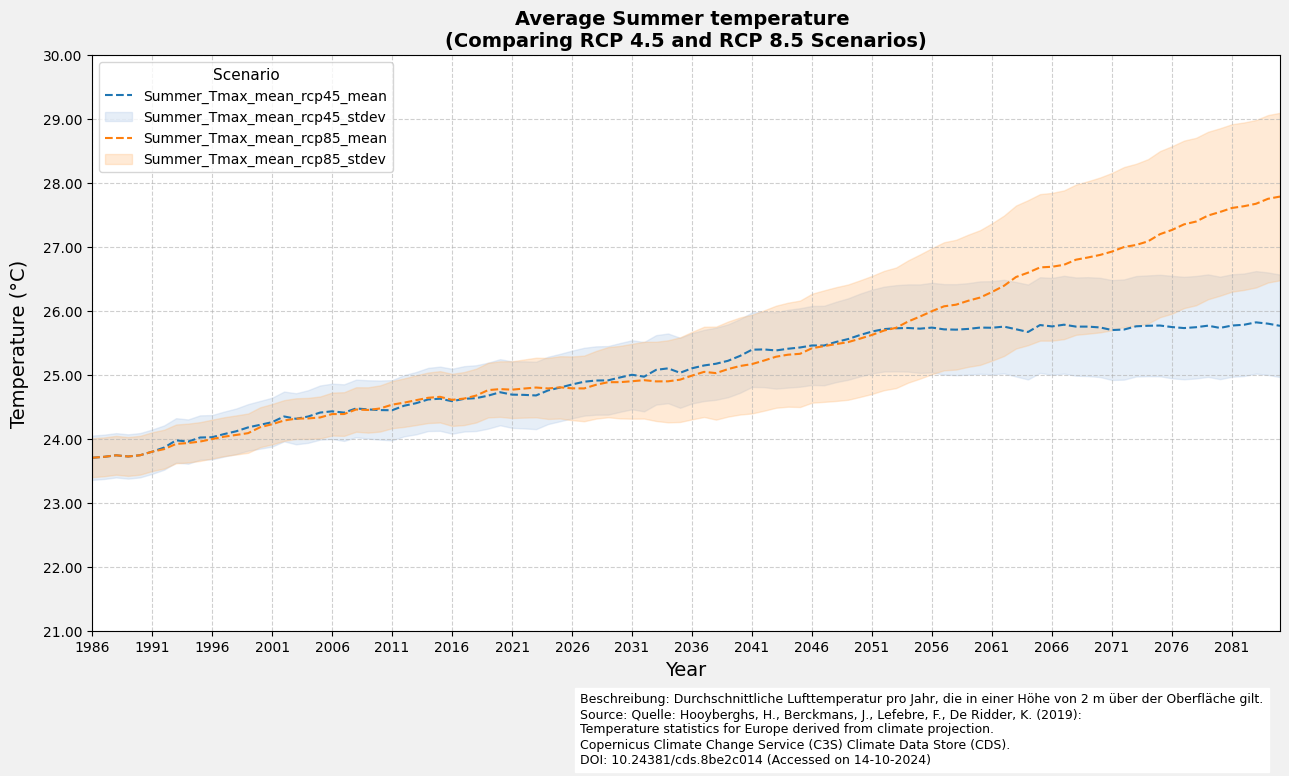

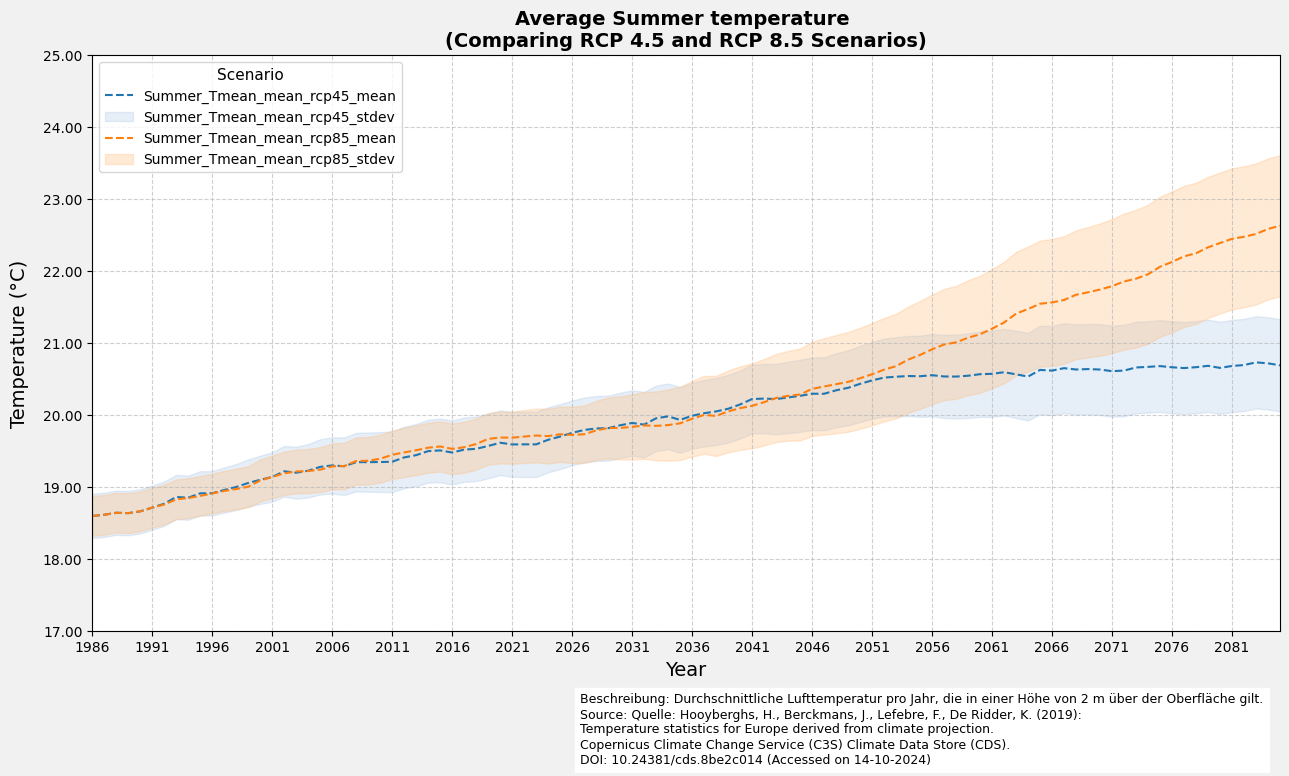

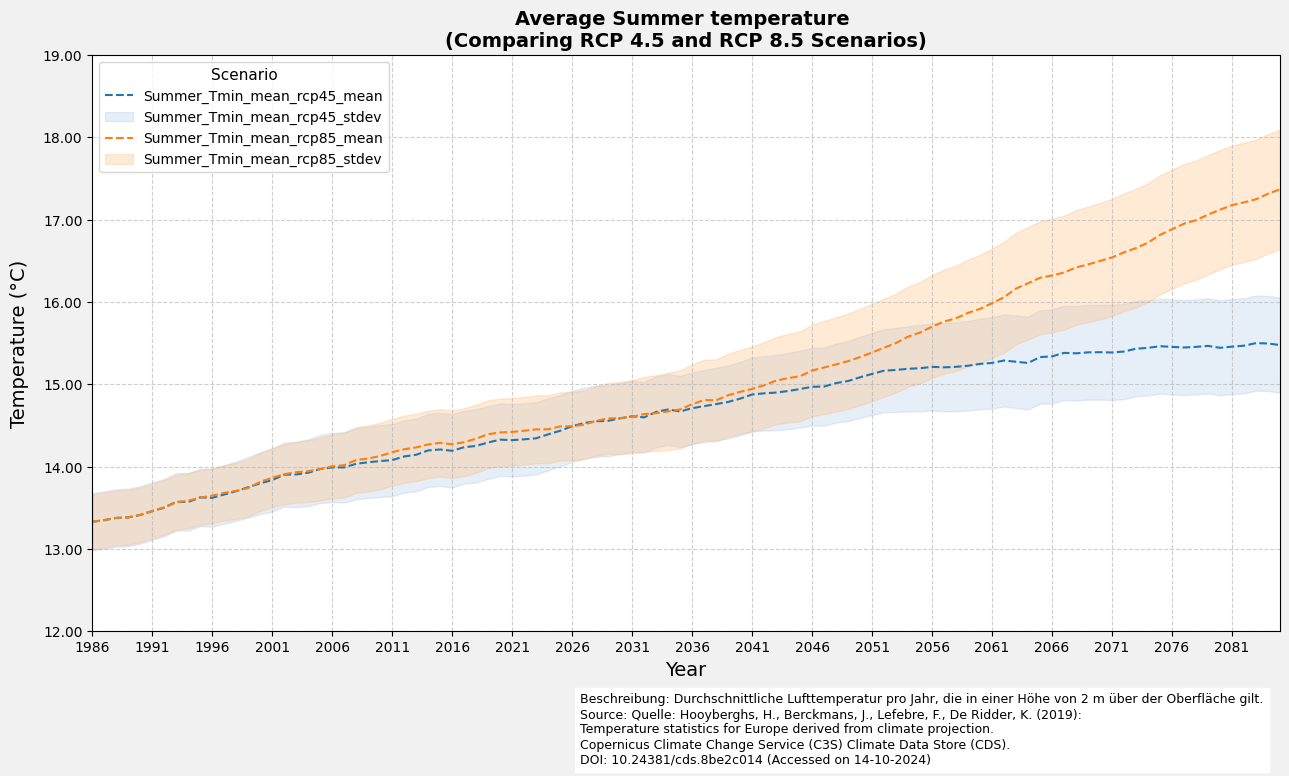

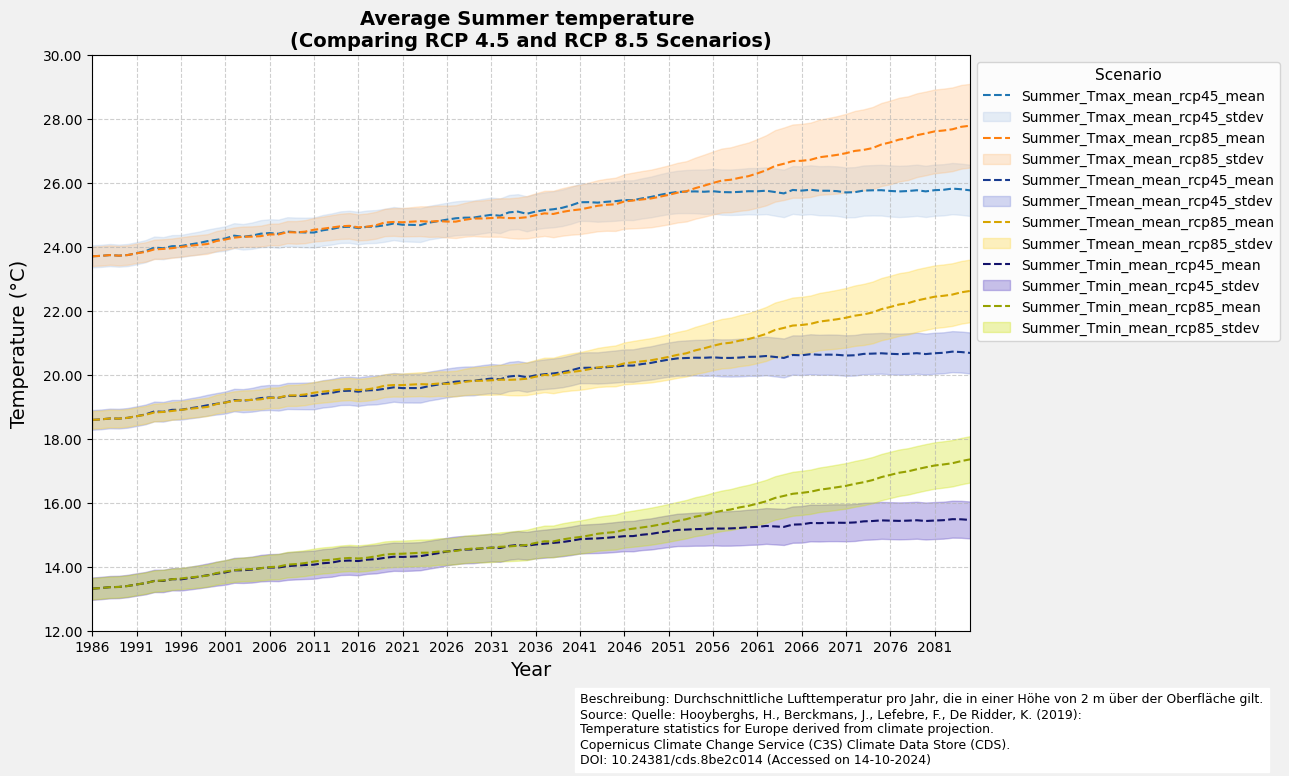

In [25]:
if __name__ == "__main__":
    # Single dataset variable
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files[0]['ds_period']}_Tmax_mean"])
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files[0]['ds_period']}_Tmean_mean"])
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files[0]['ds_period']}_Tmin_mean"])
    # Multiple dataset variable
    plot_line_and_shade(filtered_df_average=filtered_df_average,
                         variable_name_list=[f"{nc_files[0]['ds_period']}_Tmax_mean",
                                             f"{nc_files[0]['ds_period']}_Tmean_mean",
                                             f"{nc_files[0]['ds_period']}_Tmin_mean"])
    